In [1]:

#package imports
# UTILS
from datetime import datetime,time,timedelta
import os
## PLOT
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
## MATH
from scipy.optimize import curve_fit as curvefit
import numpy as np




## ASTROPY
from astropy.io import fits
from astropy.time.core import Time, TimeDelta
from astropy.table import Table
import astropy.units as u

import ancillary_functions as af
import spectroscopy_functions as sf

# All new functions

In [2]:
# import files
# L4 spectrogram
sci_file = "data/solo_L1_stix-sci-xray-spec_20220830T020459-20220830T081003_V02_2208301654-61465.fits"
# BKG file
bkg_file= "data/solo_L1_stix-sci-xray-cpd_20220911T021423-20220911T030223_V02_2209115148-62679.fits"


In [3]:
# information in the files
print("\nBKG information:")
hdulist_bkg = fits.open(bkg_file)
header_bkg = hdulist_bkg[0].header
af.print_obs_info(header_bkg)

print("SCI information:")
hdulist = fits.open(sci_file)
header = hdulist[0].header
af.print_obs_info(header)


BKG information:
Observatory: Solar Orbiter
Instrument: STIX
Observation time:
 from: 2022-09-11T02:14:23.017
 to: 2022-09-11T03:02:23.022
Distance s/c - sun: 0.6452445535300616 AU
Time delay s/c - sun: 321.9801189557256 s
SCI information:
Observatory: Solar Orbiter
Instrument: STIX
Observation time:
 from: 2022-08-30T02:04:59.812
 to: 2022-08-30T08:10:03.650
Distance s/c - sun: 0.764934298901394 AU
Time delay s/c - sun: 381.705874472152 s


#### Extraction


Now you can extract the data tables and headers with defined functions (we already reviwed together most how its done). Also, functions for the quicklooks, spectrogram and bin integration plots. 


the elements 'tables' contains the data, energy info and header of the provided file. you can obtain these elements from the SCI file alone (obtaining RAW counts), or directly correct the counts by providing a BKG file too.

In [4]:

#EXAMPLE - ONLY SCI
#tables = get_tables(sci_file_path=sci_file)

#EXAMPLE - SCI and BKG
tables = sf.remove_bkg(sci_file,bkg_file)

#### Markers
Time markers can be overlayed on the plots by providing the desired (formatted) times to be highlighted. Provide a list of the strings as the parameter `markers` in the plotting functions.

In [5]:
# pay attention to date the format, the markers will only work when date is provided in this format
mark = ["2022-08-30 04:50:10"]

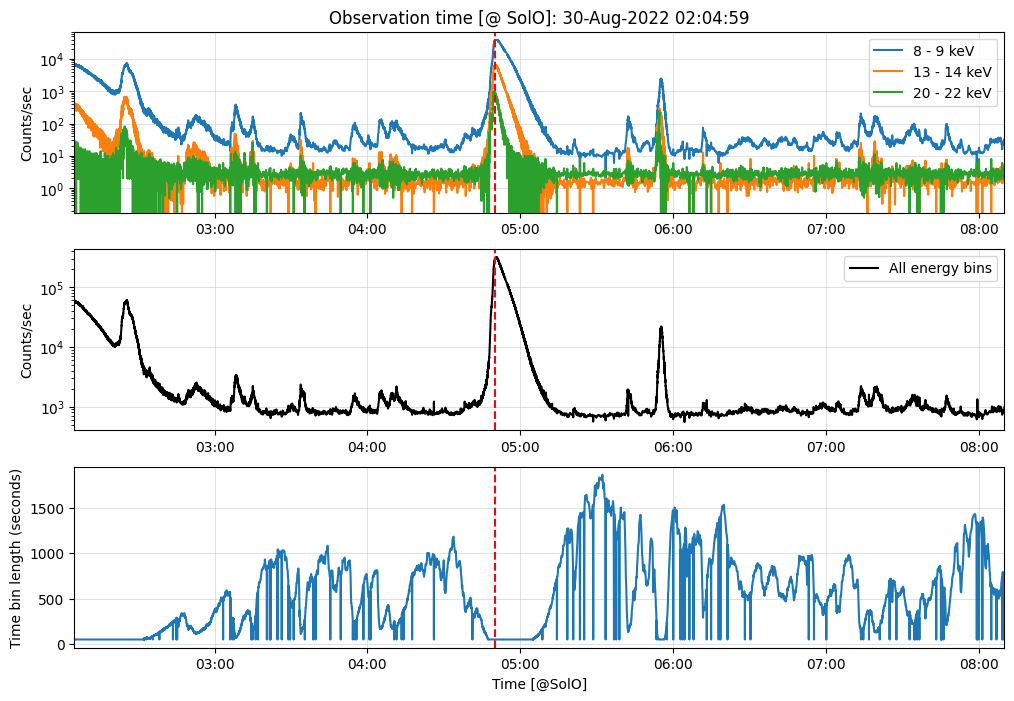

In [6]:

sf.plot_quicklooks(*sf.get_tables(sci_file_path=sci_file),plot_channels=[5,10,15],markers=mark)

#### Background subtracted and raw data
for the 'spectrogram' and 'integrated bins' exists the option of plotting the RAW counts (not yet corrected) or the corrected counts by using the paramater `corrected` when calling the plot functions (default False). Have into account that if your 'tables' element is product of just extracting the SCI file (without using BKG) you may have problems using 
```
corrected = True 
```

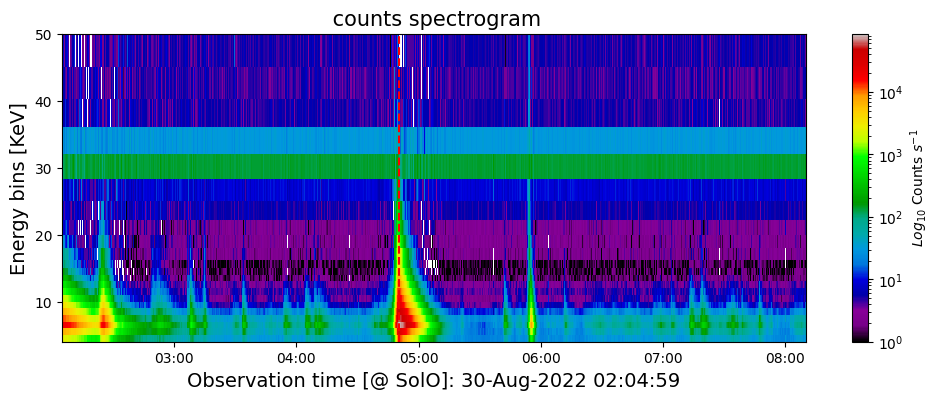

In [7]:
# lets first see the raw counts
sf.plot_spectrogram(*tables,energy_range=[4,50],markers=mark,corrected=False)

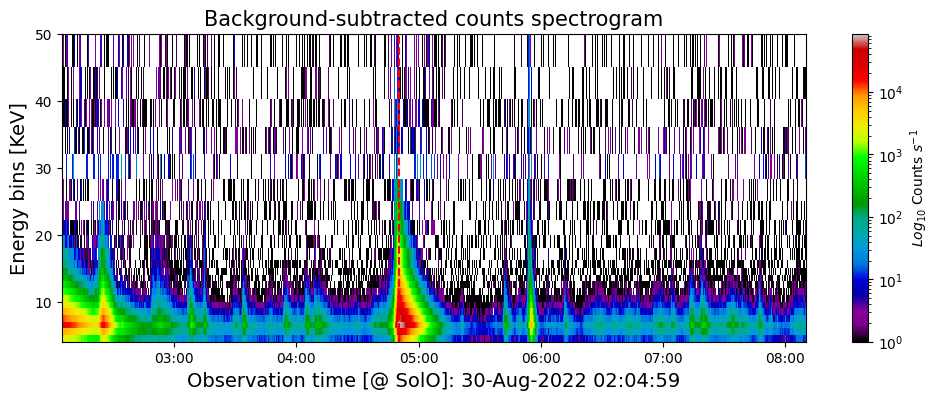

In [8]:
# now lets see the background subtracted spectrogram
sf.plot_spectrogram(*tables,energy_range=[4,50],markers=mark,corrected=True)

#### Smoothing and cropping
Integrating in time is also an useful tool when observing lightcurves as it might supress the influence of noise and quick variations. By doing a moving average in time (using a few neighbors) the curve is smoothed so that he curve trend is better seen.  

For the energy  bins integration plot and quicklooks plot in addition to provide the `energy bins`, you can also "smooth" the curve by providing the `smooth_pts` parameter (default None). When provided, a moving average (that averages `smooth_pts` points) is used to soften the curve. Using a value between 5 and 15 is recomended. 

As you might see, the spectrogram files contain information of several hours that at the same time contain multiple flares. In order to focus on a smaller time interval you can also provide a 'time range' to crop the time axis to your convenience. you can use this 'time_range' parameter in the quicklook, spectrogram and integrated_bins plot functions.

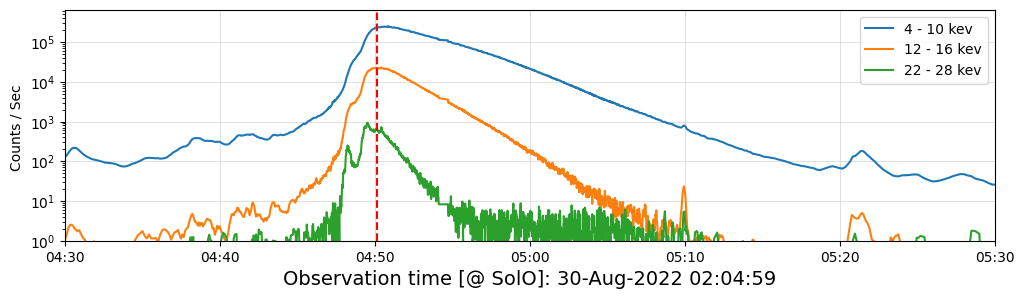

In [9]:
time_range = ["2022-08-30 04:30:00","2022-08-30 05:30:00"]
sf.plot_integrated_bins(*tables,energy_bins=[[4,10],[12,16],[22,28]],corrected=True,smooth_pts=4,markers=mark, time_range=time_range)

**Activity -** Try different energy intervals and "smoothing points" value. **Why is  it useful to smooth the lightcurves?** How does using a large "smooth_pts" value affect the peak position at different energy ranges?  Do you notice any pattern between the peaks at different energy ranges and their timing?

#### Background spectrum
For background-subtracted tables, you can plot the background spectrum subtracted from the counts data.

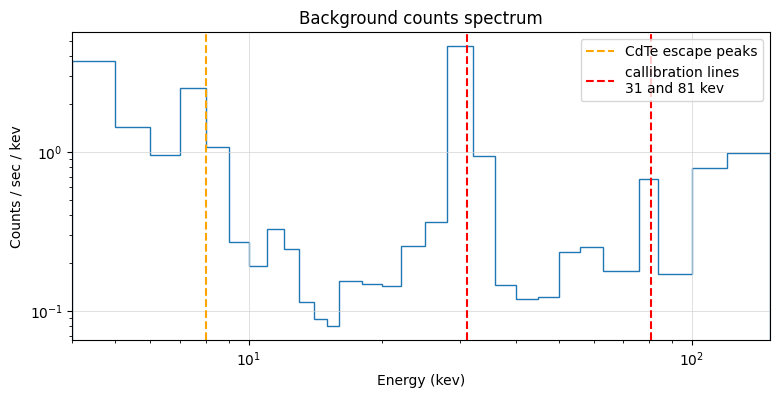

In [10]:
sf.plot_bkg_spectrum(*tables)

# Spectroscopy

With the background counts spectrum removed from the total counts spectrum, now it's possible to study the spectrum of **the flare itself** . 

For such purpose, we will start by isolating the desired **time interval**: it will be long enough to have enough counts (for favoring the statistics), but not too long so we can have a better understanding of impulsive changes (fast) in the flare energy spectrum. The usual interval durations range **between ~50 seconds  up to ~150 seconds (2min30s)**, depending on the intensity of the flare at different energy ranges. The idea is to **find a balanced value for the interval length** given the count rate it contains: you might need a longer interval duration for times where you dont have many counts (and vice versa).



In [11]:
# ACTIVITY - use the provided funcitons to define the desired interval (with 2 markers in chronological order) 
# Continue to the next section once you have stablished which interval you want to study.
markers_interval = ["2022-08-30 04:48:00","2022-08-30 04:48:40"]
# Remember: 
#   * more counts provide better statistics, thus intervals with Xray emission peaks are recommended
#   * it cannot be too long as we also want to study the impulsive changes in th spectrum
#
# For the next steps is important that the markers are in chronological order in the list 

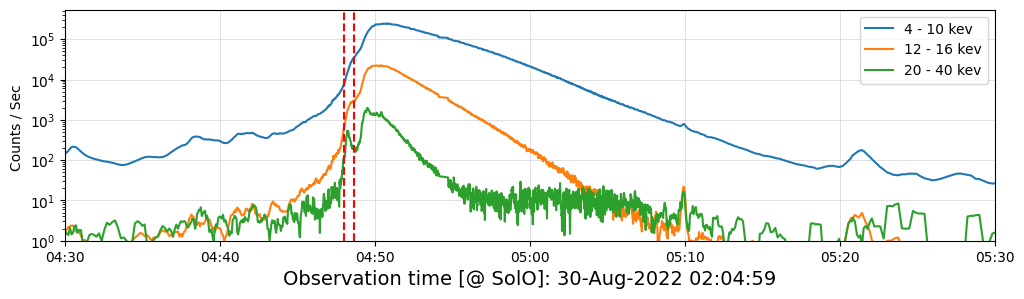

In [12]:
sf.plot_integrated_bins(*tables,energy_bins=[[4,10],[12,16],[20,40]],corrected=True,smooth_pts=5,markers=markers_interval,time_range=time_range)


### accumulating counts and cropping the interval

In [13]:
data,energies,header = tables
# convert marker boundaries to datetime objects 
dt_markers = [Time(x).datetime for x in markers_interval]
# estimate the difference btween the boundaries in seconds
dur_sec = (dt_markers[1]-dt_markers[0]).seconds
print("Interval duration:",dur_sec," seconds")

Interval duration: 40  seconds


In [14]:
# indexes where time is within the markers interval
ii = np.logical_and( data["time"].datetime>=dt_markers[0] , data["time"].datetime<=dt_markers[1] )
jj = np.where(ii)[0]


Now, let's add all the flare counts within the selected interval. As the count rate is known, we can use the time bin length (timedel) to retieve the corrected counts. 

In [15]:
# correcting the counts

# create a target array of the same shape as corrected cts/sec array
corr_cts = np.zeros(np.shape(data["corrected_cts_per_sec"]))

#for each time bin , multiply by the timedel (to pass from cts/sec to counts) 
for i in range(np.shape(data["corrected_cts_per_sec"])[0]):
    corr_cts[i,:] =  data["corrected_cts_per_sec"][i,:]*data["timedel"][i]/100
    


Sum over the time axis and estimate the count rate per kev at each energy bin. We call the obtained spectrum the **Flare counts spectrum**

In [16]:
# add all counts within interval (along time axis)
summed_counts = np.sum(data["corrected_counts"][jj,:],axis=0)
# counts/sec spectrum
spectrum_interval = summed_counts/energies["mean_energy"]/dur_sec
spectrum_bkg = data["bkg_cts_per_sec"][0]/energies["mean_energy"][1:]

Estimate as well the counts spectrum for the raw counts for comparison

In [17]:
#using  same process for the raw counts to compare 
uncorr_counts = data["counts"]/(data["timedel"]/100).reshape(-1,1)
# add all counts within interval (along time axis)
summed_raw_counts = np.sum(data["counts"][jj,:],axis=0)
# counts/sec spectrum
spectrum_raw_interval = summed_raw_counts/energies["mean_energy"]/dur_sec


Text(0.5, 1.0, 'Spectrum comparison')

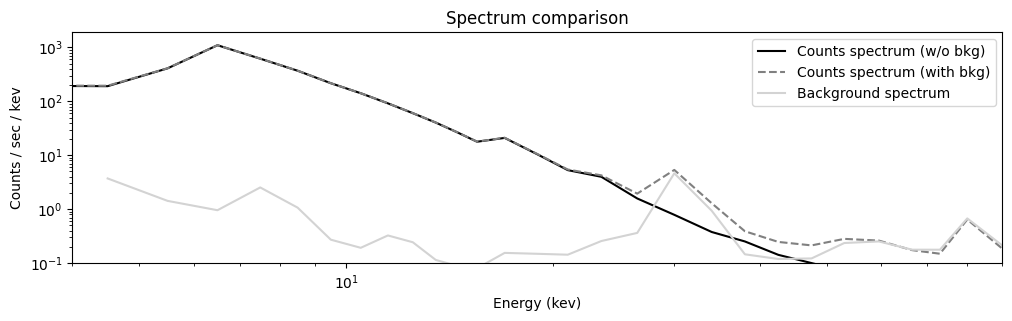

In [18]:
# define the  plotting energy range 
# (lower bound is always 4, you can set the high boundary depending on your data)
E_range = [4,90]

plt.figure(figsize=(12,3))
plt.loglog(energies["mean_energy"],spectrum_interval,c="k",label="Counts spectrum (w/o bkg)")
plt.loglog(energies["mean_energy"],spectrum_raw_interval,c="gray",ls="--",label="Counts spectrum (with bkg)")
plt.loglog(energies["mean_energy"][1:],spectrum_bkg,c="lightgray",label="Background spectrum")
plt.xlim(*E_range)
plt.ylim(bottom=0.1)

plt.legend()
plt.xlabel("Energy (kev)")
plt.ylabel("Counts / sec / kev")
plt.title("Spectrum comparison")

### stepwise representation
Using this representation is useful to see the difference in spectrum value per energy bin one by one. the boundaries of the energy bin define the length and position of each step, and the specrtum defines the height. 

Let's first create the energy bin edges. Logically, for n spectrum values there must be n+1 edge values and since the last bin's boundary is infinity, must take precautions.

In [19]:
e_edges = list(energies["e_high"][:-1]) # every e_high value except the last one
e_edges = np.array([e_edges[0]] + e_edges + [e_edges[-1]]) #repeat the las edge value

(0.1, 1916.1641322364103)

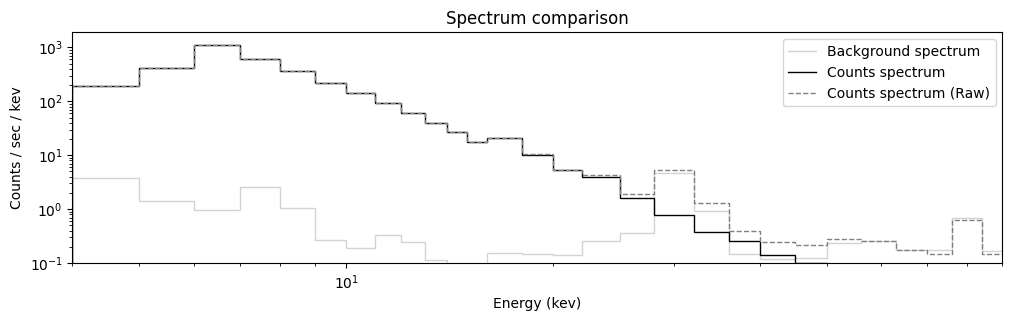

In [20]:
plt.figure(figsize=(12,3))
plt.stairs(spectrum_bkg,edges=e_edges[1:],color="lightgray",label="Background spectrum")
plt.stairs(spectrum_interval,edges=e_edges,color="k",label="Counts spectrum")
plt.stairs(spectrum_raw_interval,edges=e_edges,color="gray",ls="--",label="Counts spectrum (Raw)")


plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Energy (kev)")
plt.ylabel("Counts / sec / kev")
plt.title("Spectrum comparison")
plt.xlim(*E_range)
plt.ylim(bottom=0.1)


You might notice a nearly straight line with negative slope in the interval after ~8 kev. The slope of this line is the **index of the non-thermal part of the counts spectrum**. This line is observed in the log-log space, therefore
$$
\log(y) = m  \log(x) + b
$$
where y is spectrum value (cts/sec/kev) and x is the energy. The counts spectrum index is m . This definition leads to the powerlaw
$$
y = e^b x^a
$$
The next step is to find this powerlaw in the energy range where the slope is more or less constant. From the resulting fit we obtain the desired index. 

In [21]:
# define the linear fit for the log space (x=log(energy), output=log(spec) ) 
def nonthermalindex(x, a, b):
    return a * x + b
# for the slope m and constant b that are found, we need a function to go from energy to spec (the powerlaw)
def inv_nonthermalindex(x,a,b):
    return np.exp(b)*(x**a)

The linear fit is done in the interval where this trend is better seen. An average interval for this is the interval 8-16 keV, but **you might want to modify this energy range** depending on the spectrum you're handling. 

In [22]:
# energy range to do the fit
fit_range=[8,35]

# select the energy indexes in the energy fit range
energy_idx = np.where((energies['mean_energy']>=fit_range[0]) & (energies['mean_energy']<=fit_range[1]))[0]
# indexes for the bin edges
energy_idx_edge = np.insert(energy_idx,energy_idx.size,energy_idx[-1]+1)

# perform the curve fit
# the linear fit is faster (done in the log-log space)
popt, pcov = curvefit(nonthermalindex, np.log(energies['mean_energy'][energy_idx]),np.log(spectrum_interval)[energy_idx])
# associated deviaitons are diagonal of covariance matrix
err= pcov.diagonal()

# once obtained the coefficents m and b, create the curve corresponding to the fit using the powerlaw
fit_result = inv_nonthermalindex(energies["mean_energy"][energy_idx],*popt)

print('Spectral index = ',round(popt[0],3),'+-',round(err[0],3))

Spectral index =  -4.821 +- 0.014


Text(0.5, 1.0, 'Spectrum comparison')

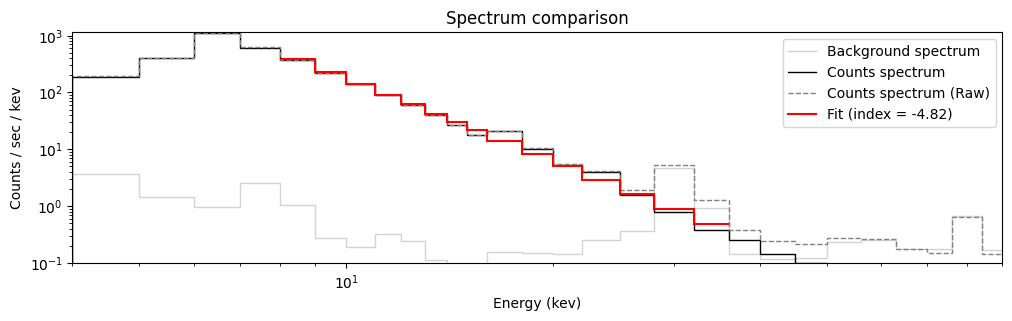

In [23]:
plt.figure(figsize=(12,3))
plt.stairs(spectrum_bkg,edges=e_edges[1:],color="lightgray",label="Background spectrum")
plt.stairs(spectrum_interval,edges=e_edges,color="k",label="Counts spectrum")
plt.stairs(spectrum_raw_interval,edges=e_edges,color="gray",ls="--",label="Counts spectrum (Raw)")

plt.stairs(fit_result,edges=e_edges[energy_idx_edge],color="r",
           label=f"Fit (index = {round(popt[0],2)})",baseline=None,lw=1.5)
plt.xlim(*E_range)
plt.ylim(bottom=0.1)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Energy (kev)")
plt.ylabel("Counts / sec / kev")
plt.title("Spectrum comparison")

**Congratulations!** You obtained the **index** of the non-thermal part of the counts spectrum  for the interval you selected. As the slope is negative (higher count rates at lower energies), is expected that by increasing the count rate at higher energies the slope becomes "flatter" (closer to zero). We say that a X-ray spectrum is **harder** than other when the slope is closer to zero (never positive) due to the presence of **Hard X-Ray**. 

**Activity** Compare the index of different instants of the flare. What pattern can you notice? How would the background affect the value of the index? do you see any correlation between the corrected spectrum and the background spectrum?

You can use the functions below to replicate the spectrum plot we did before:

Interval duration: 40  seconds


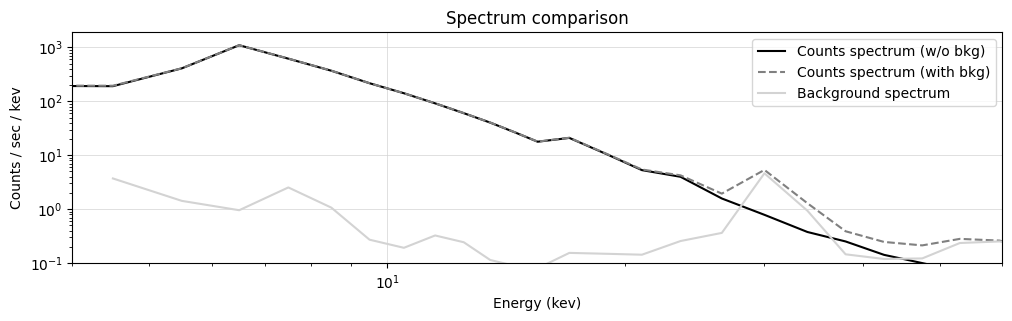

In [24]:
# to plot the spectrum of a selected time interval and within a given energy range (e_range)
sf.plot_spectrum(*tables,selected_interval=markers_interval, e_range = [4,60])


Interval duration: 40  seconds
Spectral index =  -4.686 +- 0.012


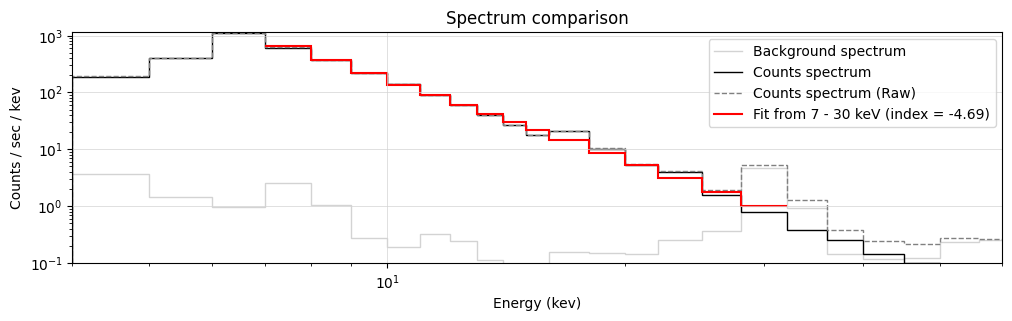

In [25]:
# to fit the spectrum (of a selected time interval) in a given energy range (e_range_fit)
# naturally, e_range_fit must be within the energy boundaries set by e_range
sf.do_powerlaw_fit(*tables,selected_interval=markers_interval,e_range_fit=[7,30], e_range = [4,60])

# Detector Response Matrix (DRM)
STIX onboard data handling is based on “science energy channels” (energy channels we've been using) whose boundaries in keV must be well-matched among all detectors and pixels. Therefore it is essential that a current energy calibration be maintained on board to support the real-time conversions from the counts per energy bin  to science energy channels (photon energies in keV). This calibration is expected to drift not only over mission timescales as the detectors age and accumulate radiation damage but also on shorter timescales as the detector temperature changes.

The counts data we've used in previous exercises corresponds to the incident photon spectrum convoluted with the response in the detector (given its efficiency at different energy levels), all this added to the background counts. In general,
$$
C  = P \ast M + B
$$
where C are the detector counts, P are the incident photon spectrum on the detector, M is the detector response per energy bin (DRM) and B is the background count rate. Given that we already subtracted the background counts B, the natural next step to obtain the photon energy spectrum from the counts would be to deconvolve the DRM. 

Unfortunately, since the spectroscopy software is not available in Python, we cannot generate the necessary DRM to process these counts. Instead, we can take a look of a DRM file (for a diferent set of counts) to get familiar with its structure and the information it contains about the energy bins. 

In [30]:
drm_file = "data/stx_srm_20211028_1505.fits"

In [31]:
hdulist_drm = fits.open(drm_file)
header_drm = hdulist_drm[0].header
header_drm

SIMPLE  =                    T / Written by IDL:  Wed Jan 26 11:43:22 2022      
BITPIX  =                    8 /                                                
NAXIS   =                    0 /                                                
EXTEND  =                    T / File contains extensions                       
DATE    = '2022-01-26T11:43:22' / File creation date (YYYY-MM-DDThh:mm:ss UTC)  
ORIGIN  = 'STIX    '           / Spectrometer Telescope for Imaging X-rays      
OBSERVER= 'Unknown '           / Usually the name of the user who generated file
TELESCOP= 'Solar Orbiter'      / Name of the Telescope or Mission               
INSTRUME= 'STIX    '           / Name of the instrument                         
OBJECT  = 'Sun     '           / Object being observed                          
TIME_UNI=                    1 /                                                
ENERGY_L=              4.00000 /                                                
ENERGY_H=              120.0

The DRM is estimated with ground-based software using the on-board callibration files sent back to earth. Therefore, the estimated DRM does not contain information about on-board observation (longitude, latitude, etc)  

In [32]:
data_drm = Table(hdulist_drm[1].data)
data_drm

ENERG_LO,ENERG_HI,N_GRP,F_CHAN,N_CHAN,MATRIX
float64,float64,int16,int32,int32,float32[29]
3.9270000000000005,4.0,1,0,29,5.170821e-06 .. 0.0
4.0,4.073,1,0,29,8.0166765e-06 .. 0.0
4.073,4.218999999999999,1,0,29,1.3398235e-05 .. 0.0
4.218999999999999,4.365,1,0,29,4.6994643e-05 .. 0.0
4.365,4.510999999999999,1,0,29,0.00012486831 .. 0.0
4.510999999999999,4.657,1,0,29,0.0002883178 .. 0.0
...,...,...,...,...,...
148.90499999999997,149.051,1,0,29,0.0011761019 .. 7.308945e-05
149.051,149.197,1,0,29,0.0011749244 .. 7.1878734e-05


In [33]:
energies_drm = Table(hdulist_drm[2].data)
energies_drm

CHANNEL,E_MIN,E_MAX
int32,float32,float32
0,4.0,5.0
1,5.0,6.0
2,6.0,7.0
3,7.0,8.0
4,8.0,9.0
5,9.0,10.0
...,...,...
22,50.0,56.0
23,56.0,63.0


The data is organized such that each **photon energy** (in bins) has a response in **counts** for each **detector energy channel**. 

In [34]:
drm_matrix = np.array(data_drm["MATRIX"])
n_channels= len(energies_drm["CHANNEL"])
print(np.shape(drm_matrix))
print(n_channels," energy channels")

(1027, 29)
29  energy channels


## Detector response to a fixed photon energy

Let's choose a set of photon energies, and for each of them , lets plot the it's response in all energy bins.

Text(0, 0.5, 'Counts / photon / kev')

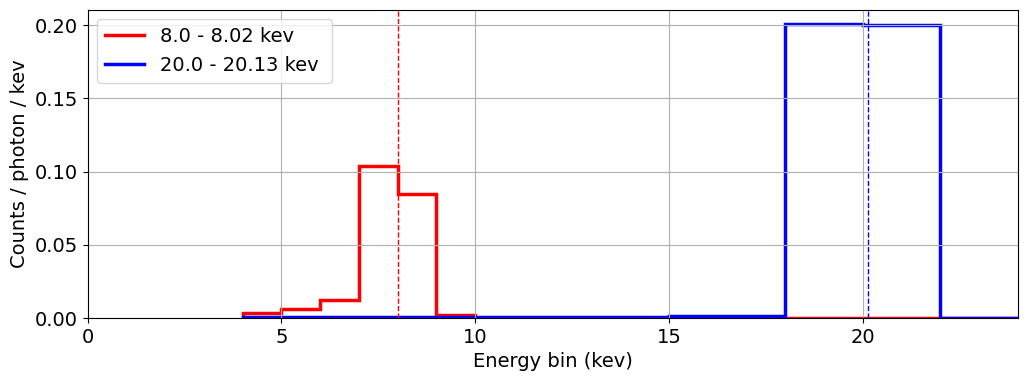

In [35]:
# set of energies to plot (default is 8 and 20, but please try more values [max. 120] ) 
energy_to_plot = [8,20]

#  choose the photon energy index for each of the selected photon energies 
plot_ph_channels = []
for eb in energy_to_plot:
    plot_ph_channels.append( np.where(np.logical_and(data_drm["ENERG_LO"]<=eb , data_drm["ENERG_HI"]>eb))[0][0] )

# colors for plotting
colors = ["red","blue","green","orange","cyan","magenta","limegreen"]

#choose the bin edges 
edges = list(energies_drm["E_MIN"]) + [energies_drm["E_MAX"][-1]]



## PLOT 
plt.figure(figsize=(12,4))
plt.rcParams.update({'font.size': 14})
ax = plt.subplot(111)
# for each photon energy channel
for i in range(len(plot_ph_channels)):
    pc = plot_ph_channels[i]
    #define photon energy boundaries
    emin = round(data_drm[pc]['ENERG_LO'],2)
    emax = round(data_drm[pc]['ENERG_HI'],2)
    e_lbl= f"{emin} - {emax} kev "
    # plot response for each of the detector bins
    ax.stairs(drm_matrix[pc,:],edges=edges,label=e_lbl,color=colors[i],lw=2.5)#,fill=True,alpha=0.5)
    #paint vertical line in the selected photon energy
    plt.axvline(emax,c=colors[i],linestyle="--",linewidth=1)

ax.grid()
ax.legend()
plt.ylim(bottom=0)
plt.xlim(0,1.2*np.max(energy_to_plot))
plt.xlabel("Energy bin (kev)")
plt.ylabel("Counts / photon / kev")


try plotting different energy values and different energy regimes. 

### To think about...
Are the photon arriving in the detector creating a response ONLY in the bins close to its energy value? if not, are the contributions in other detector bins relevant with respect to the response caused in the energy bins close to the photon energy value? 

select an energy value and plot some energies around the value you selected (for example, plotting  8, 9, 10 and 11 kev). Is the response in the activated energy bins varying significantly with slight changes in the photon energy?

## Sensibility of a fixed detector energy channel to different photon energies

Now that we've seen the response of photons of specific energy in the detector, it would be interesting to see the DRM from other angle: let's fix an energy channel and plot the contribution of each photon energy per detector count. from what we obvserved in the previous exercise, it can be inferred that an energy channel will not have a response for photons with an energy lower than the channel energy range.

Text(0, 0.5, 'Counts / photon / kev')

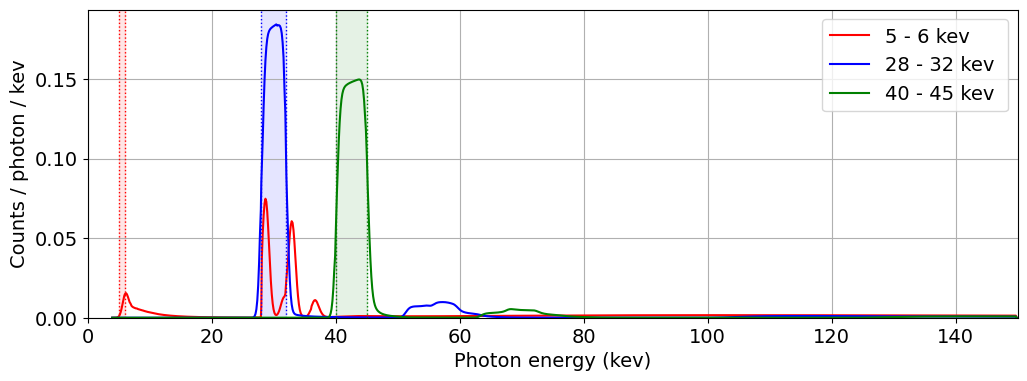

In [36]:
plot_channels = [1,17,20]

colors = ["red","blue","green","orange","cyan","magenta","limegreen"]

#photon energy
drm_energy_avg = ( np.array(data_drm["ENERG_LO"]) + np.array(data_drm["ENERG_HI"]) )/2


plt.figure(figsize=(12,4))

ax = plt.subplot(111)
for i in range(len(plot_channels)):
    pc = plot_channels[i]
    emin = int(energies_drm[pc]['E_MIN'])
    emax = int(energies_drm[pc]['E_MAX'])
    e_lbl= f"{emin} - {emax} kev "
    ax.plot(drm_energy_avg,drm_matrix[:,pc],label=e_lbl,color=colors[i])
    plt.axvspan(emin, emax, color=colors[i], alpha=0.1)
    plt.axvline(emin,c=colors[i],linestyle=":",linewidth=1)
    plt.axvline(emax,c=colors[i],linestyle=":",linewidth=1)

ax.grid()
ax.legend()
plt.ylim(bottom=0)
plt.xlim(0,150)
plt.xlabel("Photon energy (kev)")
plt.ylabel("Counts / photon / kev")


## Approxiamtion to a diagonal response
From the total counts in a given detector energy channel, how many of these counts correspond to phtons with energies that are within the energy channel bondaries? Given that the DRM is not a square matrix, we can not solve this question by checking at the value of the diagonal. What can be done is to estimate the rate $C_{in}/C_{total}$, where $C_{in}$ is the summed response of photon energies within the channel energy range, and $C_{total}$ is the summed response of all photon energies. With this we will measure for each energy channel the proportion of counts corresponding to in-range photon energies.

In [37]:
# target matrix (where we fill in information)
diagonal_response = np.zeros((n_channels))

# for each energy channel
for i in range(n_channels):
    #d efine eenrgy boundaries
    emin = int(energies_drm[i]['E_MIN'])
    emax = int(energies_drm[i]['E_MAX'])
    
    # indexes of photon enrgies within channel energy range
    ii = np.where(np.logical_and( drm_energy_avg>=emin , drm_energy_avg<emax ))[0]
    
    # select respose of in-range photon energies and sum (Cin)
    selected_response = drm_matrix[ii,i]
    sum_sel_response = np.sum(selected_response,axis=0)
    
    # response of all total energies and sum (Ctotal)
    total_response = drm_matrix[:,i]
    sum_tot_response = np.sum(total_response,axis=0)
    
    # proportion 
    diagonal_response[i] = sum_sel_response/sum_tot_response


Text(0, 0.5, 'counts / photon / kev')

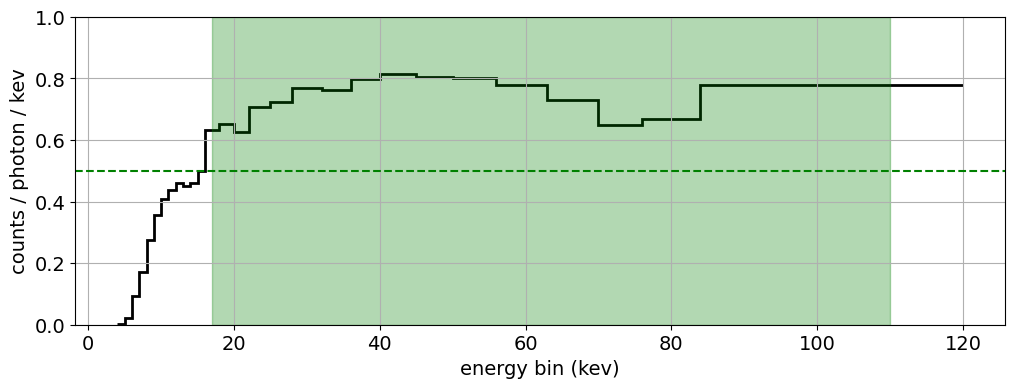

In [38]:
# lets highlight the channels for which the proportion is above a threshold
threshold = 0.5
# a value from 0 to 1



# energy channel edges
edges = list(energies_drm["E_MAX"])
edges=[energies_drm["E_MIN"][0]]+edges

# energy channel average enegy
bin_avg = (np.array(energies_drm["E_MIN"]) + np.array(energies_drm["E_MAX"]))/2



# PLOT
plt.figure(figsize=(12,4))
ax1 = plt.subplot(111)
# plot step function - diagonal response per energy channel
ax1.stairs(diagonal_response,edges=edges,baseline=None,color="k",linewidth=2)
# highlight energy channels xith diagonal response over threshold
ax1.fill_between(bin_avg, 0, 1, where=diagonal_response > threshold,
                color='green', alpha=0.3,)
ax1.grid()
plt.axhline(threshold,c="g",ls="--")
plt.ylim(0,1)
plt.xlabel("energy bin (kev)")
plt.ylabel("counts / photon / kev")

### To think about ...
Why is useful to have an idea of this diagonal response per energy bin? What can this say about the photon spectrum obtained after deconvolving the DRM? What can you say about the shape of the plot at low and high energies?  